# Imports

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.metrics import balanced_accuracy_score
from scipy.sparse import csr_matrix
from datetime import datetime

# Part 1 ‑ Exploratory data analysis
The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute
time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [7]:
logins = pd.read_json('logins.json')

In [8]:
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [9]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [10]:
Min15_login_count = logins.resample('15Min', on='login_time').count()
hour_login_count = logins.resample('H', on='login_time').count()
day_login_count = logins.resample('D', on='login_time').count()
week_login_count = logins.resample('W', on='login_time').count()

In [11]:
day_login_count.describe()

,login_time
count,103.000000
mean,904.291262
std,347.167463
min,112.000000
25%,643.000000
50%,827.000000
75%,1141.000000
max,1889.000000


On average, there are 904 logins each day, with 112 being the fewest seen and 1889 being the most logins seen in a day

We can see some ebb and flow of the data, but it is hard to see with the number of datapoints over the course of a few months.  Therefore we will break into the data more by breaking it down by hour, day, week and weekday.  

<AxesSubplot:xlabel='login_time'>

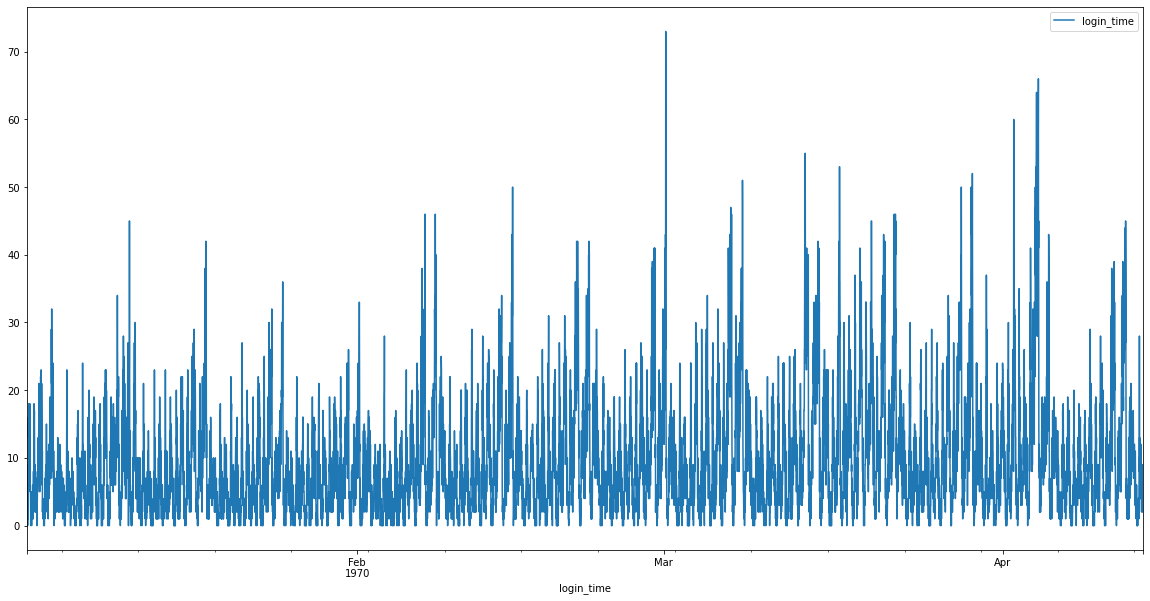

In [12]:
Min15_login_count.plot(figsize=(20,10))

## What is the average hour that users are logging in?

<AxesSubplot:xlabel='login_time'>

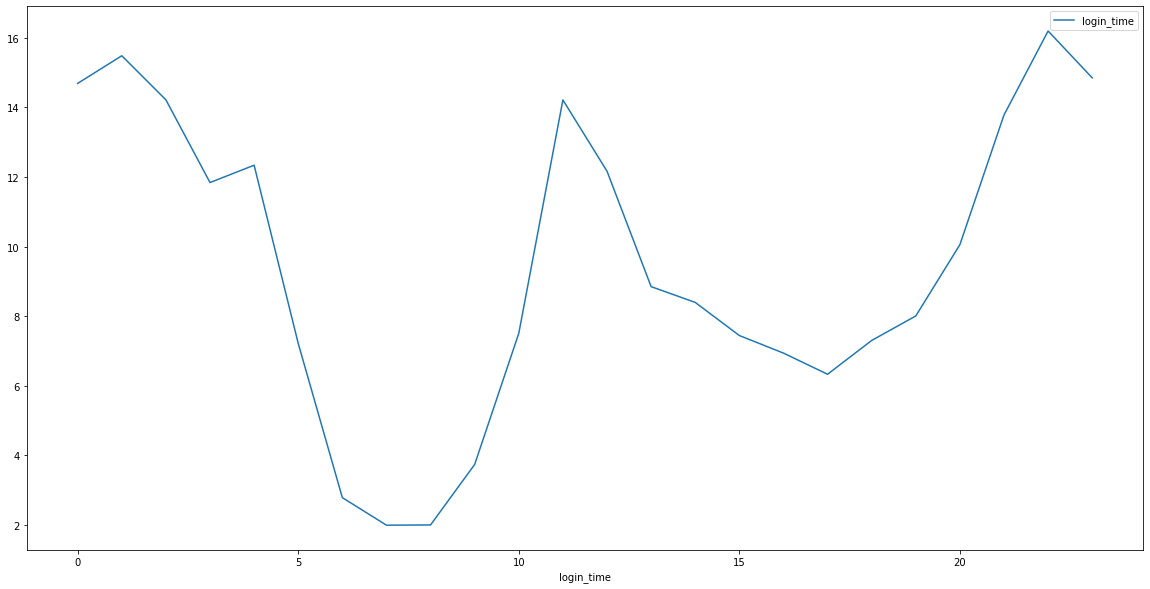

In [13]:
Min15_login_count.groupby(Min15_login_count.index.hour).mean().plot(figsize=(20,10))

Which day of the week had the highest average login? According to the [documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html), Monday is denoted by 0 and Sunday is 6.  Therefore the highest average logins would occur on Saturdays.  My assumption is that logins peak every weekend, and the overall trend is a general increase in weekend logins.

<AxesSubplot:xlabel='login_time'>

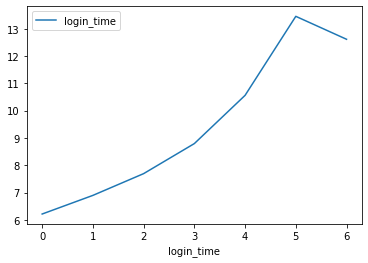

In [14]:
Min15_login_count.groupby(Min15_login_count.index.weekday).mean().plot()

Which day of the month had the highest average logins?

<AxesSubplot:xlabel='login_time'>

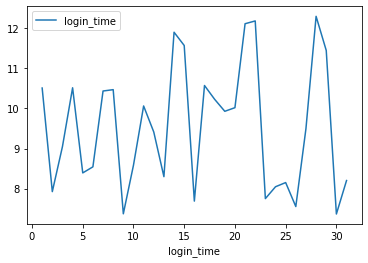

In [15]:
Min15_login_count.groupby(Min15_login_count.index.day).mean().plot()

Now that we have a better idea of some of the average trends in the data, we are going to use seasonal decomposition to remove the cyclical nature of the data.  Based on the weekday breakdown, there seems to be a 'season' of a week, so we will see what the decomposition shows.  

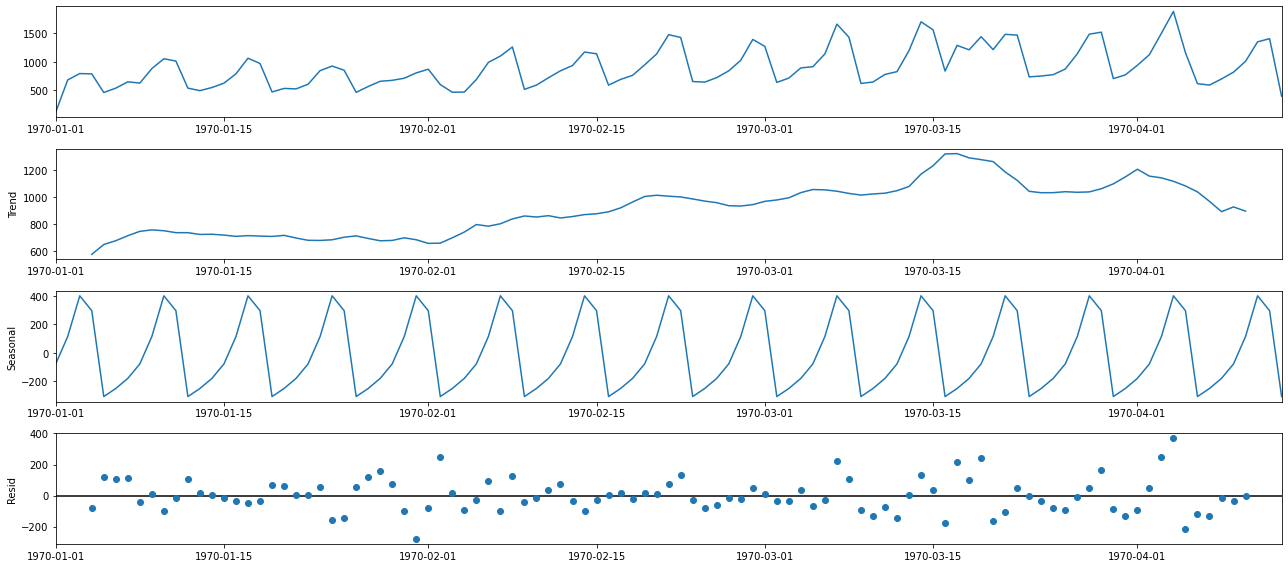

In [16]:
rcParams['figure.figsize'] = 18, 8

decomposition = seasonal_decompose(day_login_count)
fig = decomposition.plot()
plt.show()

As we can see, there is a seasonality to the data.  By looking at the calendar, days like 02/06/1970 and 02/20/1970 are Fridays.  This means that the peak just beyond those days would correspond with a Saturday, just like the average plots showed.  There has also been an increase in logins from January to a peak near the end of March.  

# Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
    
    a. how you will implement the experiment
    b. what statistical test(s) you will conduct to verify the significance of the observation
    c. how you would interpret the results and provide recommendations to the city operations team along with any caveats.

1) Number of tolls costs reimbursed by hour.  By choosing this metric, Ultimate can see how many drivers have successfully been encouraged to serve both cities.  By choosing number of tolls reimbursed by hour instead of just number of tolls, it captures which city's drivers were better convinced to serve both cities.

2) To implement this experiment, an A/B test would be set up with a control group not getting tolls paid for.  To test the statistical significance of the experiment, a baseline of the number of drivers who pay the toll and service both cities.  Ultimate should then determine the amount of increase needed to warrent paying for the two way toll.  After determining the Confidence Level, the sample size needed for this test can be determined.  After running the experiment, if the p-value generated is less than significance level of the confidence interval, the results are statistically significant. If the results are significant, Ultimate would be able to see whether paying for the toll encourages driver partners to serve both cities.  With the key metric, Ultimate can see whether driver partners in both cities were equally encouraged to serve both cities.  If the weekday number of tolls reimbursed in the morning greatly outnumbers the weekday evening toll numbers, the Ultimate Gotham drivers were more convinced to serve both cities, and Ultimate can look into why the Metropolis drivers were not.  Likewise, looking at the weekend reimbursed tolls, it can be determined to not pay for tolls because the driver partners are needed in their own cities.

# Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.

1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its longterm
rider retention (again, a few sentences will suffice).

# Data description

* city: city this user signed up in
* phone: primary device for this user
* signup_date: date of account registration; in the form ‘YYYY MM DD’
* last_trip_date: the last time this user completed a trip; in the form ‘YYYY MM DD’
* avg_dist: the average distance in miles per trip taken in the first 30 days after signup
* avg_rating_by_driver: the rider’s average rating over all of their trips
* avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
* surge_pct: the percent of trips taken with surge multiplier > 1
* avg_surge: The average surge multiplier over all of this user’s trips
* trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
* ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
* weekday_pct: the percent of the user’s trips occurring during a weekday

# Import and EDA

In [76]:
df = pd.read_json('ultimate_data_challenge.json')

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [78]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


How many users were active in the last 30 days?

In [79]:
#convert column to datetime
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])
df['signup_date'] = pd.to_datetime(df['signup_date'])

In [80]:
# Find last date to create snapshot date to back calculate 30 days
snapshot = pd.to_datetime(df['last_trip_date'].max())

In [81]:
snapshot

Timestamp('2014-07-01 00:00:00')

In [82]:
#Create Binary classification of active/not active in last 30 days from last recorded day.
df['Active?'] = np.where((snapshot-df['last_trip_date']) < pd.Timedelta(30,'D'),1,0)

In [84]:
df['Active?'].value_counts()[1]

18310

What percentage of users does this represent?

In [85]:
(df['Active?'].value_counts()[1]/df.shape[0])*100

36.620000000000005

Here are the number of missing values per column in the dataset

In [86]:
df.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
Active?                      0
dtype: int64

As we do not have any intuition behind the null values, we will drop them.  With 50,000 samples, this should not have much impact

In [87]:
df.dropna(inplace=True)

What percentage os users were active in the last 30 days after removing the missing values?

In [88]:
(df['Active?'].value_counts()[1]/df.shape[0])*100

40.07238508867174

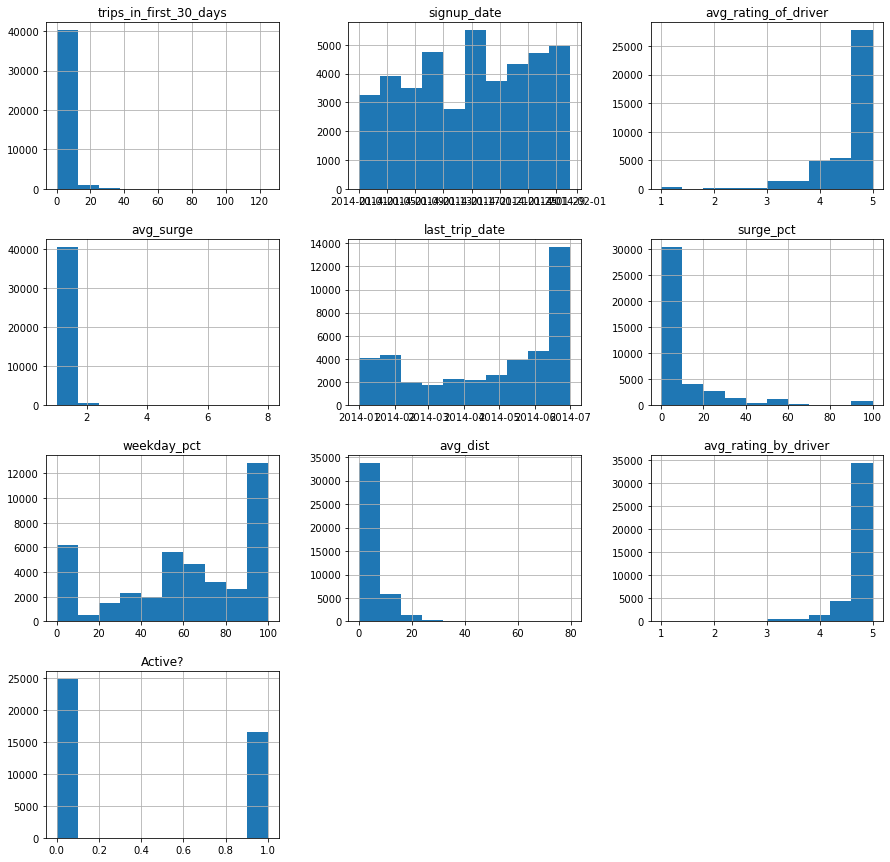

In [89]:
df.hist(figsize=(15,15));

In [90]:
#To remove datetime variables, we will encode those features as numerical representations.  This prevents pd.get_dummies from creating a new column for each date
df['days_since_last_trip'] = (snapshot-df['last_trip_date']).dt.days
df['day_of_signup'] = (df['signup_date']- datetime.strptime('2014/01/01', "%Y/%m/%d")).dt.days

In [91]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active?,days_since_last_trip,day_of_signup
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,1,14,24
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,0,57,28
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,0,175,5
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,1,2,9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,0,108,26


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   city                    41445 non-null  object        
 1   trips_in_first_30_days  41445 non-null  int64         
 2   signup_date             41445 non-null  datetime64[ns]
 3   avg_rating_of_driver    41445 non-null  float64       
 4   avg_surge               41445 non-null  float64       
 5   last_trip_date          41445 non-null  datetime64[ns]
 6   phone                   41445 non-null  object        
 7   surge_pct               41445 non-null  float64       
 8   ultimate_black_user     41445 non-null  bool          
 9   weekday_pct             41445 non-null  float64       
 10  avg_dist                41445 non-null  float64       
 11  avg_rating_by_driver    41445 non-null  float64       
 12  Active?                 41445 non-null  int32 

In [93]:
df_copy = df.copy(deep=True)

In [94]:
# Encode Dummy Features and remove the previously encoded datetime features
df_copy = pd.get_dummies(df_copy)
X = df_copy.drop(['signup_date','last_trip_date','Active?'], axis=1)
y = df_copy['Active?']

In [95]:
df_copy

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,Active?,days_since_last_trip,day_of_signup,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,True,46.2,3.67,5.0,1,14,24,0,1,0,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,False,50.0,8.26,5.0,0,57,28,1,0,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,False,100.0,0.77,5.0,0,175,5,1,0,0,0,1
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,True,80.0,2.36,4.9,1,2,9,0,1,0,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,False,82.4,3.13,4.9,0,108,26,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49993,3,2014-01-03,4.8,1.11,2014-07-01,11.1,True,55.6,2.53,4.7,1,0,2,1,0,0,0,1
49994,1,2014-01-03,4.6,1.44,2014-05-31,37.5,False,25.0,2.25,4.5,0,31,2,1,0,0,0,1
49995,0,2014-01-25,5.0,1.00,2014-06-05,0.0,False,100.0,5.63,4.2,1,26,24,0,1,0,0,1
49997,0,2014-01-31,5.0,1.00,2014-05-22,0.0,True,100.0,3.86,5.0,0,40,30,0,0,1,1,0


# Model Preparation and Selection

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, random_state=42)
model = RandomForestClassifier()
clf = model.fit(X_train, y_train)
y_pred = clf.predict(X_test)
target_names = ['Not Active', 'Active']
clf_rep = classification_report(y_test, y_pred, target_names=target_names)

In [97]:
print(clf_rep)

              precision    recall  f1-score   support

  Not Active       1.00      1.00      1.00      7427
      Active       1.00      1.00      1.00      5007

    accuracy                           1.00     12434
   macro avg       1.00      1.00      1.00     12434
weighted avg       1.00      1.00      1.00     12434



In [98]:
train_pred = clf.predict(X_train)
train_bal_acc = balanced_accuracy_score(y_train, train_pred)
test_bal_acc = balanced_accuracy_score(y_test, y_pred)

results = pd.DataFrame({'Train Balanced Accuracy': train_bal_acc, 'Test Balanced Accuracy': test_bal_acc}, index = ['df'])
print(results)

    Train Balanced Accuracy  Test Balanced Accuracy
df                      1.0                     1.0


# Which features are most important?

In [99]:
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
days_since_last_trip,0.803545
avg_rating_by_driver,0.037791
surge_pct,0.026742
city_King's Landing,0.025790
avg_surge,0.020227
weekday_pct,0.018067
ultimate_black_user,0.010761
phone_iPhone,0.010278
phone_Android,0.009826
avg_dist,0.008485


As the days_since_last_trip is how we encoded the target variable, it will be ignored. We can then see that things like avg_rating_by_driver, the surge_pct, signing up in King's Landing, and the avg_surge are the biggest reasons for customers being retained.  Users seem to be sensitive to the surge percentage and avg surge, so Ultimate may be able to retain more customers by investigating those further.  A better way to solve this problem would be to have data on a few successive cohorts, as well as data from the time of signing up until the 6 month mark.  Without that, it is hard to see what lead to the comprehensive loss of users.  